# Finite Differences with MIRGE

In this code-along, we will put together a (very) simple finite-difference wave equation solver using the MIRGE machinery.

First, we need to import the ingredients:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import arraycontext
import pyopencl as cl
from pytools.obj_array import make_obj_array

In [3]:
%load_ext gvmagic

In [4]:
cl_ctx = cl.create_some_context(interactive=True)
queue = cl.CommandQueue(cl_ctx)

Choose platform:
[0] <pyopencl.Platform 'Intel(R) OpenCL Graphics' at 0x47b45d0>
[1] <pyopencl.Platform 'Portable Computing Language' at 0x7fb722fe7788>


Choice [0]: 1


Set the environment variable PYOPENCL_CTX='1' to avoid being asked again.


To start, we will need an array context. We will base ours on the existing Pytato + OpenCL one. We need to say how we would like to transform our loopy program. Let's return it unchanged for now:

In [5]:
class SimpleArrayContext(arraycontext.PytatoPyOpenCLArrayContext):
    def transform_loopy_program(self, t_unit):
        #beginclear
        return t_unit
        #endclear

actx = SimpleArrayContext(queue)

To get started, we'll need a simple mesh infrastructure.

Observe how `actx` is being used:

In [6]:
class Mesh:
    def __init__(self, size_x, size_y, resolution):
        self.size_x = size_x
        self.size_y = size_y
        self.resolution = resolution
        self.nx, self.ny = int(size_x*resolution), int(size_y*resolution)

        self.x = actx.np.linspace(
                0, size_x, self.nx, endpoint=False).reshape(self.nx, 1)
        self.y = actx.np.linspace(
                0, size_y, self.ny, endpoint=False).reshape(1, self.ny)
        self.hx = actx.to_numpy(self.x[1, 0] - self.x[0, 0])
        self.hy = actx.to_numpy(self.y[0, 1] - self.y[0, 0])

    def plot(self, f, **kwargs):
        f = actx.to_numpy(f)
        return plt.imshow(f.T[::-1], extent=(0, self.size_x, 0, self.size_y),
                          **kwargs)

    def set_plot_data(self, img, f):
        f = actx.to_numpy(f)
        img.set_data(f.T[::-1])

    def zeros(self):
        return actx.zeros((self.nx, self.ny), dtype=np.float64)

    def norm(self, u):
        return actx.np.sqrt(actx.np.sum(abs(u)**2)) * (
                self.size_x * self.size_y / (self.nx - 1) / (self.ny -1))

mesh = Mesh(size_x=6, size_y=4, resolution=64)

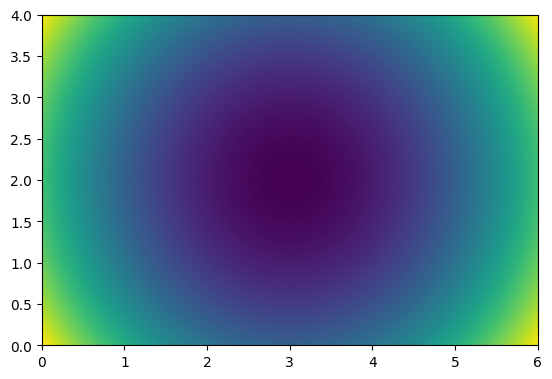

In [6]:
f = (mesh.x - mesh.size_x/2)**2 + (mesh.y - mesh.size_y/2)**2
mesh.plot(f)

Next up, define and test a derivative operator along the $x$ axis:

0.026279337003535012


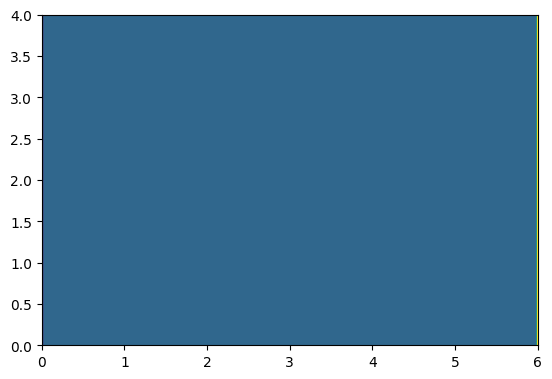

In [7]:
#clear

def d_dx(mesh, u):
    padded = actx.np.concatenate((
        u[0:1, :],
        u,
        u[-2:-1, :],
        ), axis=0)
    return (padded[2:] - padded[:-2])/(2*mesh.hx)

df_dx = 2*(mesh.x - mesh.size_x/2)
df_dx_num = d_dx(mesh, f)
assert df_dx_num.shape == f.shape

err = df_dx - df_dx_num
print(actx.to_numpy(mesh.norm(err)))
mesh.plot(err)

We will now head towards time-dependent simulation. For this, we need a simple Runge-Kutta scheme:

In [8]:
def rk4_step(y, t, h, f):
    k1 = f(t, y)
    k2 = f(t+h/2, y + h/2*k1)
    k3 = f(t+h/2, y + h/2*k2)
    k4 = f(t+h, y + h*k3)
    return y + h/6*(k1 + 2*k2 + 2*k3 + k4)

And we will make use of a "bump" function as a source term:

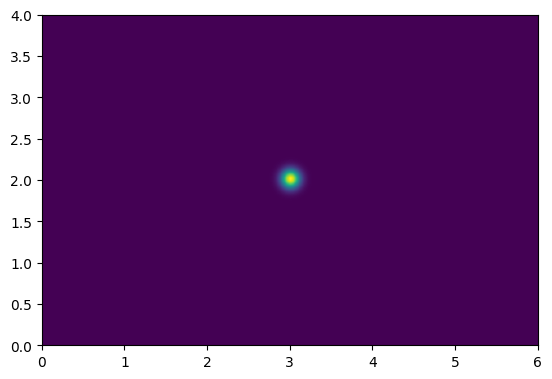

In [9]:
bump = actx.np.exp(-80*((mesh.x - mesh.size_x/2)**2 + (mesh.y - mesh.size_y/2)**2))
mesh.plot(bump)

Next, let us move closer to an actual wave equation solver. To do so, define:

- A function `laplace(mesh, u, boundary_val)`
- The RHS: `rhs(t, s)`. Use a time-dependent source term $\sin(30t)\cdot \text{bump}$.
- A function realizing a whole time step: `tstep(t, s)`
- A time step `dt` obeying a CFL condition.

In [10]:
def laplace(mesh, u, boundary_val):
    padded_x = actx.np.concatenate((
        actx.np.full((1, mesh.ny), boundary_val),
        u,
        actx.np.full((1, mesh.ny), boundary_val),
        ), axis=0)
    padded_y = actx.np.concatenate((
        actx.np.full((mesh.nx, 1), boundary_val),
        u,
        actx.np.full((mesh.nx, 1), boundary_val),
        ), axis=1)
    return (
            (padded_x[2:] - 2*u + padded_x[:-2])/mesh.hx**2
            +
            (padded_y[:, 2:] - 2*u + padded_y[:, :-2])/mesh.hy**2
            )

def rhs(t, s):
    u, du_dt = s

    return make_obj_array([
        du_dt + actx.np.sin(30*t) * bump,
        laplace(mesh, u, 0)
        ])

def tstep(t, s):
    return rk4_step(s, t, dt, rhs)

dt = min(mesh.hx, mesh.hy)

Here's our initial condition:

In [11]:
state = make_obj_array([mesh.zeros(), mesh.zeros()])
t = 0.

Next, take a few time steps (code up one and hit Ctrl-Enter):

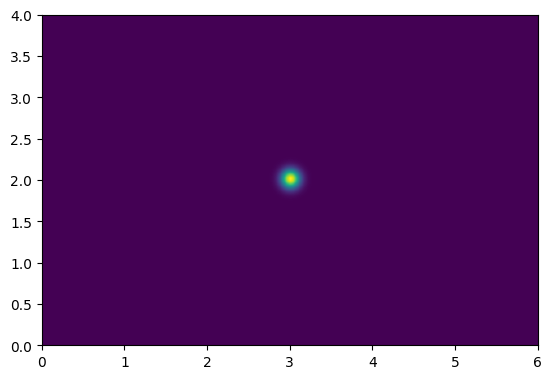

In [12]:
#clear

state = tstep(t, state)
t += dt

mesh.plot(state[0])

What do you observe? Can you fix the issue? (Again, use a Ctrl-Enter loop):

In [13]:
t = 0.
state = make_obj_array([mesh.zeros(), mesh.zeros()])

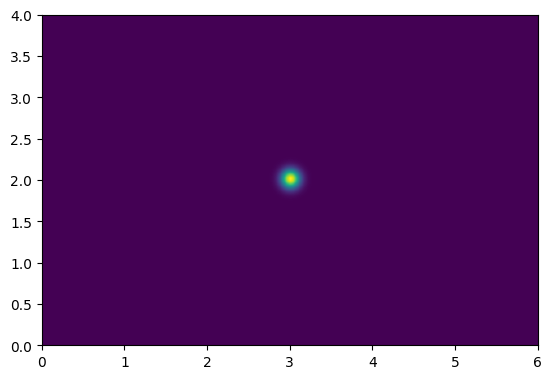

In [14]:
#clear
state = tstep(t, state)
t += dt

state = actx.thaw(actx.freeze(state))
mesh.plot(state[0])

What do you notice about step-to-step time? Can you fix this issue?

In [15]:
t = 0.
state = make_obj_array([mesh.zeros(), mesh.zeros()])

In [16]:
#clear
tstep_compiled = actx.compile(tstep)

/tmp/ipykernel_649057/1210679733.py:2: DeprecationWarning: Argument array '(1, 0)' to a compiled function is unevaluated. Evaluating just-in-time, at considerable expense. This is deprecated and will stop working in 2023. To avoid this warning, force evaluation of all arguments via freeze/thaw.
  state = tstep_compiled(t, state)
/tmp/ipykernel_649057/1210679733.py:2: DeprecationWarning: Argument array '(1, 1)' to a compiled function is unevaluated. Evaluating just-in-time, at considerable expense. This is deprecated and will stop working in 2023. To avoid this warning, force evaluation of all arguments via freeze/thaw.
  state = tstep_compiled(t, state)


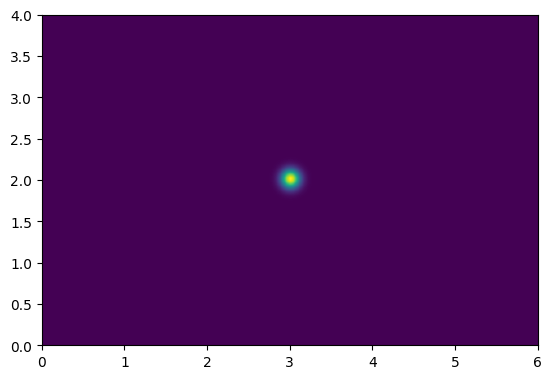

In [17]:
#clear
state = tstep_compiled(t, state)
t += dt

state = actx.thaw(actx.freeze(state))
mesh.plot(state[0])

Here's an animation to convince you that a PDE got solved:

In [18]:
t = 0.
state = make_obj_array([mesh.zeros(), mesh.zeros()])

fig = plt.figure()
img = mesh.plot(state[0], vmin=-0.02, vmax=0.02)

def update(frame):
    global t, state
    for i in range(10):
        state = tstep_compiled(actx.from_numpy(t), state)
        t += dt
    mesh.set_plot_data(img, state[0])

import matplotlib.animation as animation
ani = animation.FuncAnimation(fig=fig, func=update, frames=40, interval=30)

from IPython.display import HTML
html = HTML(ani.to_jshtml())
plt.clf()
html

/tmp/ipykernel_649057/965300982.py:10: DeprecationWarning: Argument array '(1, 0)' to a compiled function is unevaluated. Evaluating just-in-time, at considerable expense. This is deprecated and will stop working in 2023. To avoid this warning, force evaluation of all arguments via freeze/thaw.
  state = tstep_compiled(actx.from_numpy(t), state)
/tmp/ipykernel_649057/965300982.py:10: DeprecationWarning: Argument array '(1, 1)' to a compiled function is unevaluated. Evaluating just-in-time, at considerable expense. This is deprecated and will stop working in 2023. To avoid this warning, force evaluation of all arguments via freeze/thaw.
  state = tstep_compiled(actx.from_numpy(t), state)


<Figure size 640x480 with 0 Axes>

For the remainder of this code-along, we will investigate various questions relating to the performance of our solver.

- First, how often did `rhs` get called above? (investigate this by modifying the code above)
    - What are the implications of that?
    - What if there are `if` statements in your code?
    
- Next, can we see the C code that was generated "under the hood"?

In [19]:
class CodeViewingArrayContext(arraycontext.PytatoPyOpenCLArrayContext):
    def transform_loopy_program(self, t_unit):
        #beginclear
        import loopy as lp
        print(lp.generate_code_v2(t_unit).device_code())
        return t_unit
        #endclear

actx = CodeViewingArrayContext(queue)

actx.compile(tstep)(0., make_obj_array([mesh.zeros(), mesh.zeros()]))

#define lid(N) ((int) get_local_id(N))
#define gid(N) ((int) get_group_id(N))
#if __OPENCL_C_VERSION__ < 120
#pragma OPENCL EXTENSION cl_khr_fp64: enable
#endif

__kernel void __attribute__ ((reqd_work_group_size(1, 1, 1))) tstep(__global double const *__restrict__ _actx_in_1_1, __global double const *__restrict__ _actx_in_1_0, __global double const *__restrict__ _actx_in_0, __global double *__restrict__ _pt_out_1, __global double *__restrict__ _pt_out_0, int const _actx_in_0_offset, int const _actx_in_1_0_offset, int const _actx_in_1_1_offset, __global double *__restrict__ _pt_temp, __global double *__restrict__ _pt_temp_0, __global double *__restrict__ _pt_temp_1, __global double *__restrict__ _pt_temp_2, __global double *__restrict__ _pt_temp_3, __global double *__restrict__ _pt_temp_4)
{
  for (int _pt_temp_dim1 = 0; _pt_temp_dim1 <= 255; ++_pt_temp_dim1)
    for (int _pt_temp_dim0 = 0; _pt_temp_dim0 <= 383; ++_pt_temp_dim0)
      _pt_temp[256 * _pt_temp_dim0 + _pt_temp_dim1] = _ac

/tmp/ipykernel_649057/1854646854.py:10: DeprecationWarning: Argument array '(1, 0)' to a compiled function is unevaluated. Evaluating just-in-time, at considerable expense. This is deprecated and will stop working in 2023. To avoid this warning, force evaluation of all arguments via freeze/thaw.
  actx.compile(tstep)(0., make_obj_array([mesh.zeros(), mesh.zeros()]))
/tmp/ipykernel_649057/1854646854.py:10: DeprecationWarning: Argument array '(1, 1)' to a compiled function is unevaluated. Evaluating just-in-time, at considerable expense. This is deprecated and will stop working in 2023. To avoid this warning, force evaluation of all arguments via freeze/thaw.
  actx.compile(tstep)(0., make_obj_array([mesh.zeros(), mesh.zeros()]))


array([DataWrapper(axes=(Axis(tags=frozenset()), Axis(tags=frozenset())), tags={}, data=<arraycontext.impl.pyopencl.taggable_cl_array.TaggableCLArray object at 0x7f36796ecc20>, _shape=(384, 256)),
       DataWrapper(axes=(Axis(tags=frozenset()), Axis(tags=frozenset())), tags={}, data=<arraycontext.impl.pyopencl.taggable_cl_array.TaggableCLArray object at 0x7f36796ecda0>, _shape=(384, 256))],
      dtype=object)

Can we see the data flow graph that was obtained?

In [20]:
dot_codes = []
class DAGViewingArrayContext(SimpleArrayContext):
    def transform_dag(self, dag):
        #beginclear
        import pytato as pt
        dot_codes.append(pt.get_dot_graph(dag))
        return dag
        #endclear

actx = DAGViewingArrayContext(queue)

actx.compile(tstep)(0., make_obj_array([actx.freeze(mesh.zeros()), actx.freeze(mesh.zeros())]))

array([DataWrapper(axes=(Axis(tags=frozenset()), Axis(tags=frozenset())), tags={}, data=<arraycontext.impl.pyopencl.taggable_cl_array.TaggableCLArray object at 0x7f367956abd0>, _shape=(384, 256)),
       DataWrapper(axes=(Axis(tags=frozenset()), Axis(tags=frozenset())), tags={}, data=<arraycontext.impl.pyopencl.taggable_cl_array.TaggableCLArray object at 0x7f3679569ee0>, _shape=(384, 256))],
      dtype=object)

In [26]:
# will only work locally, not via Jupyterhub
from pytools.graphviz import show_dot
show_dot(dot_codes[-1])

In [21]:
%dotstr dot_codes[-1]

- Can we influence the code that gets generated? Perhaps change which results end up in temporary variables?

In [30]:
import pytato as pt
class MaterializeEverythingArrayContext(CodeViewingArrayContext):
    def transform_dag(self, dag):
        #beginclear
        from pytato.transform import map_and_copy
        from pytato.tags import ImplStored
        return map_and_copy(dag, lambda node: node.tagged([ImplStored()]) if isinstance(node, pt.Array) else node)
        #endclear

actx = MaterializeEverythingArrayContext(queue)

actx.compile(tstep)(0., make_obj_array([actx.freeze(mesh.zeros()), actx.freeze(mesh.zeros())]))

#define lid(N) ((int) get_local_id(N))
#define gid(N) ((int) get_group_id(N))
#if __OPENCL_C_VERSION__ < 120
#pragma OPENCL EXTENSION cl_khr_fp64: enable
#endif

__kernel void __attribute__ ((reqd_work_group_size(1, 1, 1))) frozen_result(__global double *__restrict__ _ary)
{
  for (int _ary_dim1 = 0; _ary_dim1 <= 255; ++_ary_dim1)
    for (int _ary_dim0 = 0; _ary_dim0 <= 383; ++_ary_dim0)
      _ary[256 * _ary_dim0 + _ary_dim1] = 0.0;
}
#define lid(N) ((int) get_local_id(N))
#define gid(N) ((int) get_group_id(N))
#if __OPENCL_C_VERSION__ < 120
#pragma OPENCL EXTENSION cl_khr_fp64: enable
#endif

__kernel void __attribute__ ((reqd_work_group_size(1, 1, 1))) tstep(__global double const *__restrict__ _actx_in_1_1, __global double const *__restrict__ _actx_in_1_0, __global double const *__restrict__ _actx_in_0, __global double *__restrict__ _pt_out_1, __global double *__restrict__ _pt_out_0, int const _actx_in_0_offset, int const _actx_in_1_0_offset, int const _actx_in_1_1_offset, __global

/home/andreas/src/pyopencl/pyopencl/__init__.py:820: UserWarning: Kernel 'tstep' has 122 arguments with a total size of 976 bytes, which approaches the limit of 1024 bytes on <pyopencl.Device 'cpu-goldmont-13th Gen Intel(R) Core(TM) i7-1365U' on 'Portable Computing Language' at 0x39de6a0>. This might lead to compilation errors, especially on GPU devices.
  self._enqueue, self._set_args = generate_enqueue_and_set_args(


array([DataWrapper(axes=(Axis(tags=frozenset()), Axis(tags=frozenset())), tags={ImplStored()}, data=<arraycontext.impl.pyopencl.taggable_cl_array.TaggableCLArray object at 0x7f366ffabaa0>, _shape=(384, 256)),
       DataWrapper(axes=(Axis(tags=frozenset()), Axis(tags=frozenset())), tags={ImplStored()}, data=<arraycontext.impl.pyopencl.taggable_cl_array.TaggableCLArray object at 0x7f366ffa84a0>, _shape=(384, 256))],
      dtype=object)

* Can we estimate cost?

In [31]:
class CostAccountingArrayContext(arraycontext.PytatoPyOpenCLArrayContext):
    def transform_loopy_program(self, t_unit):
        #beginclear
        import loopy as lp
        map = lp.get_op_map(t_unit, subgroup_size=1)
        print(map)
        return t_unit
        #endclear

actx = CostAccountingArrayContext(queue)

actx.compile(tstep)(0., make_obj_array([mesh.zeros(), mesh.zeros()]))

Op(np:dtype('float64'), add, subgroup, "tstep"): { 6684672 }
Op(np:dtype('float64'), div, subgroup, "tstep"): { 1376256 }
Op(np:dtype('float64'), func:exp, subgroup, "tstep"): { 393216 }
Op(np:dtype('float64'), func:sin, subgroup, "tstep"): { 393216 }
Op(np:dtype('float64'), mul, subgroup, "tstep"): { 4521984 }
Op(np:dtype('float64'), pow, subgroup, "tstep"): { 786432 }
Op(np:dtype('int32'), add, subgroup, "tstep"): { 7667712 }
Op(np:dtype('int32'), div, subgroup, "tstep"): { 1572864 }
Op(np:dtype('int32'), mul, subgroup, "tstep"): { 393216 }



/tmp/ipykernel_649057/4102580460.py:11: DeprecationWarning: Argument array '(1, 0)' to a compiled function is unevaluated. Evaluating just-in-time, at considerable expense. This is deprecated and will stop working in 2023. To avoid this warning, force evaluation of all arguments via freeze/thaw.
  actx.compile(tstep)(0., make_obj_array([mesh.zeros(), mesh.zeros()]))
/tmp/ipykernel_649057/4102580460.py:11: DeprecationWarning: Argument array '(1, 1)' to a compiled function is unevaluated. Evaluating just-in-time, at considerable expense. This is deprecated and will stop working in 2023. To avoid this warning, force evaluation of all arguments via freeze/thaw.
  actx.compile(tstep)(0., make_obj_array([mesh.zeros(), mesh.zeros()]))


array([DataWrapper(axes=(Axis(tags=frozenset()), Axis(tags=frozenset())), tags={}, data=<arraycontext.impl.pyopencl.taggable_cl_array.TaggableCLArray object at 0x7f36794d6480>, _shape=(384, 256)),
       DataWrapper(axes=(Axis(tags=frozenset()), Axis(tags=frozenset())), tags={}, data=<arraycontext.impl.pyopencl.taggable_cl_array.TaggableCLArray object at 0x7f36794d6510>, _shape=(384, 256))],
      dtype=object)

- Can we transform the code for efficient execution on a GPU?

In [32]:
class GPUTransformArrayContext(arraycontext.PytatoPyOpenCLArrayContext):
    def transform_loopy_program(self, t_unit):
        #beginclear
        import loopy as lp
        knl = t_unit.default_entrypoint
        for iname in knl.all_inames():
            if iname.endswith("dim0"):
                knl = lp.split_iname(knl, iname, 16, outer_tag="g.1", inner_tag="l.1")
            elif iname.endswith("dim1"):
                knl = lp.split_iname(knl, iname, 16, outer_tag="g.0", inner_tag="l.0")
            else:
                raise AssertionError()
        knl = lp.set_options(knl, insert_gbarriers=True)
        t_unit = t_unit.with_kernel(knl)
        print(lp.generate_code_v2(t_unit).device_code())
        return t_unit
        #endclear

actx = GPUTransformArrayContext(queue)

actx.compile(tstep)(0., make_obj_array([mesh.zeros(), mesh.zeros()]))

#define lid(N) ((int) get_local_id(N))
#define gid(N) ((int) get_group_id(N))
#if __OPENCL_C_VERSION__ < 120
#pragma OPENCL EXTENSION cl_khr_fp64: enable
#endif

__kernel void __attribute__ ((reqd_work_group_size(16, 16, 1))) tstep(__global double const *__restrict__ _actx_in_1_1, __global double const *__restrict__ _actx_in_1_0, __global double const *__restrict__ _actx_in_0, int const _actx_in_0_offset, int const _actx_in_1_0_offset, int const _actx_in_1_1_offset, __global double *__restrict__ _pt_temp, __global double *__restrict__ _pt_temp_0, __global double *__restrict__ _pt_temp_1, __global double *__restrict__ _pt_temp_2)
{
  _pt_temp[256 * (16 * gid(1) + lid(1)) + 16 * gid(0) + lid(0)] = _actx_in_1_1[_actx_in_1_1_offset + 256 * (16 * gid(1) + lid(1)) + 16 * gid(0) + lid(0)] + sin(30.0 * _actx_in_0[_actx_in_0_offset]) * exp(-80.0 * (((((lid(1) + gid(1) * 16 + 0) % 384) % 384) * 0.015625 + -3.0) * ((((lid(1) + gid(1) * 16 + 0) % 384) % 384) * 0.015625 + -3.0) + ((((0 * 256 + lid(

/tmp/ipykernel_649057/538904145.py:20: DeprecationWarning: Argument array '(1, 0)' to a compiled function is unevaluated. Evaluating just-in-time, at considerable expense. This is deprecated and will stop working in 2023. To avoid this warning, force evaluation of all arguments via freeze/thaw.
  actx.compile(tstep)(0., make_obj_array([mesh.zeros(), mesh.zeros()]))
/tmp/ipykernel_649057/538904145.py:20: DeprecationWarning: Argument array '(1, 1)' to a compiled function is unevaluated. Evaluating just-in-time, at considerable expense. This is deprecated and will stop working in 2023. To avoid this warning, force evaluation of all arguments via freeze/thaw.
  actx.compile(tstep)(0., make_obj_array([mesh.zeros(), mesh.zeros()]))


array([DataWrapper(axes=(Axis(tags=frozenset()), Axis(tags=frozenset())), tags={}, data=<arraycontext.impl.pyopencl.taggable_cl_array.TaggableCLArray object at 0x7f366fe6c7a0>, _shape=(384, 256)),
       DataWrapper(axes=(Axis(tags=frozenset()), Axis(tags=frozenset())), tags={}, data=<arraycontext.impl.pyopencl.taggable_cl_array.TaggableCLArray object at 0x7f366f876ed0>, _shape=(384, 256))],
      dtype=object)

* How do we write robust transform code?

In [25]:
# exercise for the reader :)
# You can tag array axes in pytato, and those tags survive on loop variables ("inames") in loopy.
# You can also tag arrays.

* How can we express distributed-memory computation?

In [26]:
# exercise for the reader :)
# The necessary tools in pytato exist!